In [1]:
!nvidia-smi

Tue Jul 12 17:10:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P3    32W /  N/A |    489MiB /  8192MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 資料讀取與前處理

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

csv_files = []
for dirname, _, filenames in os.walk('MachineLearningCSV/MachineLearningCVE'):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))
        csv_files.append(csv_file)

MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\week.csv
MachineLearningCSV/MachineLearningCVE\week_2.csv


In [50]:
# 原始資料集
# df = pd.concat([pd.read_csv(file) for file in csv_files[:8]], ignore_index=True)
# 排序後資料集
df = pd.read_csv("MachineLearningCSV/MachineLearningCVE/week_2.csv")

df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 2830743
after droping null values, the length of df: 2827876


In [51]:
# 2-calss or Multiclass
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)

class_attack = ['PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot','Infiltration', 'DoS', 'Heartbleed']
df_experiment.Label.replace(class_attack, value='attack', inplace=True)
df_experiment.Label.value_counts()

BENIGN    2271320
attack     556556
Name: Label, dtype: int64

In [52]:
# data split and preprocess
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing

y = df_experiment.Label
X = df_experiment.drop(columns='Label')
labels = y.unique()

std_scaler = preprocessing.StandardScaler().fit(X)
X = std_scaler.transform(X)

classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
# print(len(df_experiment))
# print(df_experiment.Label.nunique())
# print(df_experiment.Label.value_counts())
print("after spliting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))
# print(y_train.nunique())
# print(y_train.value_counts())

(2827876, 77)
number of labels: 2
instances per label
 BENIGN    2271320
attack     556556
Name: Label, dtype: int64
labels: ['BENIGN' 'attack']
after spliting the data:

training data length: 2120907
test data length: 706969


In [53]:
# 資料前處理
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
# enc = OneHotEncoder(handle_unknown='ignore')
mm_scaler = MinMaxScaler()
le = LabelEncoder()

X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)
print("instances per label in training set\n", y_train.value_counts())
y_train = le.fit_transform(y_train)
print("instances per label in test set\n", y_test.value_counts())
y_test = le.transform(y_test)

print(X_train.shape)
print(X_test.shape)
labels_dict = dict(zip(le.classes_, range(len(le.classes_))))
print(labels_dict)


### training data sampling
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# from collections import Counter
# over = SMOTE(sampling_strategy='not majority', n_jobs=-1)
# under = RandomUnderSampler(sampling_strategy=
#                              {labels_dict['BENIGN']:200000})
# # steps = [('u', under), ('o', over)]
# steps = [('o', over)]
# pipeline = Pipeline(steps=steps)
# X_train, y_train = pipeline.fit_resample(X_train, y_train)
# counter = Counter(y_train)
# print(counter)

instances per label in training set
 BENIGN    1703490
attack     417417
Name: Label, dtype: int64
instances per label in test set
 BENIGN    567830
attack    139139
Name: Label, dtype: int64
(2120907, 77)
(706969, 77)
{'BENIGN': 0, 'attack': 1}


In [ ]:
# 資料選擇 / 目前沒做
### transform ndarray into dataframe type for later operation.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

from sklearn.feature_selection import f_classif
### Compute the ANOVA F-value 
f_value = f_classif(X_train, y_train)

# f_value = pd.Series(f_value)
# f_value.index = X_train.columns
# f_value.sort_values(ascending=False)

# ### plot the ordered f_value per feature
# f_value.sort_values(ascending=False).plot.bar(figsize=(20, 8))

### Now we select the top 10 important features based on the result above.
from sklearn.feature_selection import SelectKBest
sel_top_cols = SelectKBest(f_classif, k=10)
sel_top_cols.fit(X_train, y_train)
X_train.columns[sel_top_cols.get_support()]

### transform ndarray back:
X_train = X_train.values
X_test = X_test.values

In [33]:
#儲存資料前處理資料
import joblib as jb

# jb.dump([std_scaler, mm_scaler, le], 'model/std_mm_le_new.save')

['model/std_mm_le_new.save']

# Random Forest

In [34]:
###### Random Forest
from sklearn.ensemble import RandomForestClassifier

rng = np.random.RandomState(42)

# model = RandomForestClassifier(n_estimators = 32, random_state=rng)
# model.fit(X_train, y_train)
model = joblib.load("model/pkl/new_randomForest_32.pkl")
y_pred = model.predict(X_test)
print(y_pred)
print(y_pred.shape)

print("percentage of Anomaly:", (list(y_pred).count(1)/y_pred.shape[0])*100)
print("percentage of Legit:",(list(y_pred).count(0)/y_pred.shape[0])*100)

[0 0 1 ... 0 0 0]
(706969,)
percentage of Legit: 19.7059559895837
percentage of Anomaly: 80.2940440104163


In [38]:
y.unique()

array([0, 0, 1, ..., 0, 0, 0])

In [13]:
# 訓練前標籤未處理使用
y_true=y.copy()
attack = ['DDoS', 'PortScan', 'Bot', 'Infiltration', 'Web Attack � Brute Force', 'Web Attack � XSS', 'Web Attack � Sql Injection','DoS Hulk','DoS GoldenEye','FTP-Patator'
,'SSH-Patator','DoS slowloris','DoS Slowhttptest','Heartbleed']
normal = 'BENIGN'
y_true=y_true.replace(attack, 1)
y_true=y_true.replace(normal, 0)
y_true.unique()

array([-1, 'attack'], dtype=object)

In [31]:
print (len(y_true))
y_true.value_counts()

2830743


-1    2273097
 1     557646
Name:  Label, dtype: int64

In [39]:
# 混淆矩陣
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix

array([[567295,    535],
       [   359, 138780]], dtype=int64)

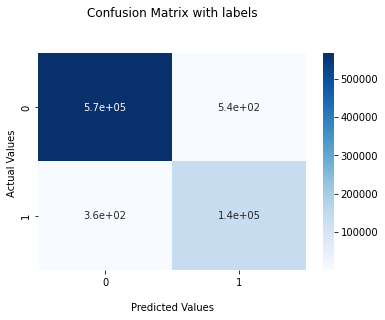

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt 
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['False','True'])
# ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
# plt.savefig('img/new_confusion_matrix_32.png')

In [45]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
def multilabel_matrix(y_true, y_pred, labels=None):
    mlm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    df_performance = pd.DataFrame(index=labels, columns=['accuracy', 'precision',
                                                         'recall', 'f1_score', 'support'])
    for i, label in enumerate(labels):
        tn, fp, fn, tp = mlm[i].ravel()
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        support = tp + fn

        f1_score = 2*precision * recall / (precision + recall)
        df_performance.loc[label] = [round(accuracy, 4), round(precision,4), \
                                     round(recall, 4), round(f1_score,4), support]
    return df_performance

In [46]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
y_train_pred_labels = le.inverse_transform(y_pred)
y_train_labels = le.inverse_transform(y_test)
print(classification_report(y_train_labels, y_train_pred_labels))

performance = multilabel_matrix(y_train_pred_labels, y_train_labels, labels=le.classes_)
performance

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    567830
      attack       1.00      1.00      1.00    139139

    accuracy                           1.00    706969
   macro avg       1.00      1.00      1.00    706969
weighted avg       1.00      1.00      1.00    706969



,accuracy,precision,recall,f1_score,support
BENIGN,0.9987,0.9991,0.9994,0.9992,567654
attack,0.9987,0.9974,0.9962,0.9968,139315


# 儲存模型檔

In [13]:
import pickle
with open('./isolationForest.pickle', 'wb') as f:
    pickle.dump(model, f)